In [1]:
import numpy as np
import pandas as pd
import gc
import time
from pickle import dump
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import pickle
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('data_useful.csv')

In [3]:
df = df.dropna()

In [4]:
df= df.reset_index()

In [5]:
df = df.drop("index", axis=1)

In [6]:
df=df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) # c'est pour enlever les caractères spécifiques, est ce bien ça?

In [7]:
df=df.drop('Unnamed0', axis=1)

In [8]:
feats = [f for f in df.columns if f not in ['TARGET', 'SK_ID_CURR']]

In [9]:
X = df[feats]

In [10]:
Y = df["TARGET"]

In [11]:
X.shape

(98954, 9)

In [12]:
Y.shape

(98954,)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [14]:

# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    silent=-1,
    verbose=-1, )

clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

filename = 'finalized_model.pickle'
pickle.dump(clf, open(filename, 'wb'))


/home/eol/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/home/eol/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/eol/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
[200]	training's auc: 0.790701	training's binary_logloss: 0.226646	valid_1's auc: 0.753213	valid_1's binary_logloss: 0.227957
[400]	training's auc: 0.805948	training's binary_logloss: 0.221248	valid_1's auc: 0.755877	valid_1's binary_logloss: 0.227368
[600]	training's auc: 0.817578	training's binary_logloss: 0.217224	valid_1's auc: 0.756142	valid_1's binary_logloss: 0.227572


In [15]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

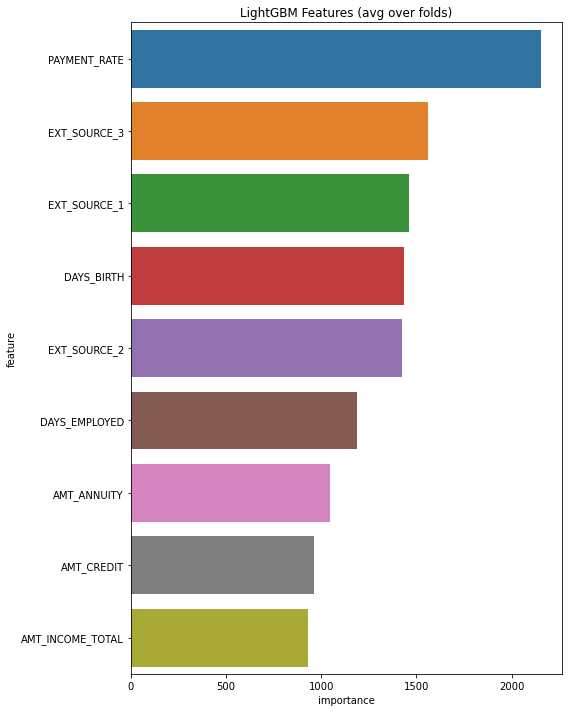

In [16]:

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = feats
feature_importance_df["importance"] = clf.feature_importances_
gc.collect()
# Write submission file and plot feature importance
display_importances(feature_importance_df)

In [45]:
feature_importance_df.to_csv("features.csv")

In [46]:
feature_importance_df

,feature,importance
0,EXT_SOURCE_1,1460
1,EXT_SOURCE_2,1426
2,EXT_SOURCE_3,1559
3,AMT_INCOME_TOTAL,928
4,DAYS_BIRTH,1433
5,AMT_CREDIT,963
6,AMT_ANNUITY,1044
7,DAYS_EMPLOYED,1189
8,PAYMENT_RATE,2155


# Test situation réelle

In [17]:
df

,SK_ID_CURR,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_INCOME_TOTAL,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,PAYMENT_RATE
0,100002,1.0,0.083037,0.262949,0.139376,202500.0,-9461,406597.5,24700.5,-637.0,0.060749
1,100009,0.0,0.774761,0.724000,0.492060,171000.0,-13778,1560726.0,41301.0,-3130.0,0.026463
2,100014,0.0,0.319760,0.651862,0.363945,112500.0,-10197,652500.0,21177.0,-679.0,0.032455
3,100016,0.0,0.464831,0.715042,0.176653,67500.0,-13439,80865.0,5881.5,-2717.0,0.072732
4,100019,0.0,0.115634,0.346634,0.678568,157500.0,-8728,299772.0,20160.0,-1157.0,0.067251
...,...,...,...,...,...,...,...,...,...,...,...
98949,456243,0.0,0.665343,0.649123,0.206779,81000.0,-16988,225000.0,12694.5,-8694.0,0.056420
98950,456244,0.0,0.896042,0.789389,0.337673,261000.0,-20390,1303812.0,35982.0,-5326.0,0.027598
98951,456247,0.0,0.243466,0.501221,0.609276,112500.0,-11870,345510.0,17770.5,-399.0,0.051433
98952,456253,0.0,0.744026,0.535722,0.218859,153000.0,-14966,677664.0,29979.0,-7921.0,0.044239


In [23]:
data_project = df.iloc[X_test.index].drop("TARGET", axis=1)
data_project = data_project.reset_index()
data_project = data_project.drop("index", axis=1)
data_project.to_csv("data_test_project.csv", index=False)

In [35]:
data_project

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_INCOME_TOTAL,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,PAYMENT_RATE
0,193423,0.686843,0.636178,0.591977,270000.0,-12478,675000.0,34596.0,-456.0,0.051253
1,111767,0.257178,0.556938,0.396220,157500.0,-11052,247500.0,6804.0,-3238.0,0.027491
2,146581,0.373096,0.659067,0.610991,180000.0,-13791,495216.0,33628.5,-5028.0,0.067907
3,348268,0.277474,0.195891,0.513694,90000.0,-9017,247275.0,19953.0,-252.0,0.080692
4,289527,0.735926,0.798341,0.591977,193500.0,-15974,270000.0,13500.0,-651.0,0.050000
...,...,...,...,...,...,...,...,...,...,...
9891,243116,0.604949,0.670272,0.483050,67500.0,-10756,298728.0,15381.0,-3668.0,0.051488
9892,256735,0.553556,0.319849,0.535276,81000.0,-11793,454500.0,44406.0,-1355.0,0.097703
9893,152136,0.526045,0.258309,0.718033,112500.0,-12479,675000.0,32602.5,-2002.0,0.048300
9894,447582,0.610064,0.709899,0.622922,67500.0,-10457,202500.0,10125.0,-1304.0,0.050000


In [24]:
with open('finalized_model.pickle', 'rb') as handle:
    model= pickle.load(handle)

In [26]:
df_api = pd.read_csv("data_test_project.csv")

In [28]:
df_api = df_api.set_index("SK_ID_CURR")

In [31]:
donnes_utilisateur = df_api.loc[193423]

In [34]:
prediction = model.predict_proba(np.array(donnes_utilisateur).reshape(1, -1)) # echantillon de 10 et 50

In [37]:
np.array(donnes_utilisateur)

array([ 6.86843174e-01,  6.36177554e-01,  5.91976618e-01,  2.70000000e+05,
       -1.24780000e+04,  6.75000000e+05,  3.45960000e+04, -4.56000000e+02,
        5.12533333e-02])

In [36]:
np.array(donnes_utilisateur).reshape(1, -1)

array([[ 6.86843174e-01],
       [ 6.36177554e-01],
       [ 5.91976618e-01],
       [ 2.70000000e+05],
       [-1.24780000e+04],
       [ 6.75000000e+05],
       [ 3.45960000e+04],
       [-4.56000000e+02],
       [ 5.12533333e-02]])

In [43]:
prediction[0]

array([0.97805084, 0.02194916])